In [2]:
from brian2 import *

/usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


In [3]:
import matplotlib.pyplot as plt

In [4]:
def randomInput(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

In [37]:
# Parameters
Cm = 100*pF
gl = 6.25*nS # This was initially 5e-5 siemens

El = -65*mV # Was -60mV
# EK = -90*mV
# ENa = 50*mV
# g_na = 100*msiemens
# g_kd = 30*msiemens
# VT = -63*mV
# Time constants

taue = 10 *ms
taui = 10 *ms

# taue_r = 5*ms
# taue_d = 5*ms

# taui_r = 10*ms
# taui_d = 10*ms

# Reversal potentials
Ee = 0*mV
Ei = -80*mV
we = 10*nS  # excitatory synaptic weight
wi = 20*nS  # inhibitory synaptic weight, was -67 nS

## Connectivity
p_CA3_CA1 = 0.05
p_CA3_I = 0.05
p_I_CA1 = 0.05

K = 10 # Number of neurons stimulated

# The model

### CA3
spiking_eqs = Equations('''
dv_/dt = (-v_+inp)/(20*ms) : 1
inp : 1
''')

### Interneurons
eqs_I = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v))/Cm : volt
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
''')

### CA1
eqs_CA1 = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v))/Cm : volt
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
''')

# ### Interneurons
# eqs_I = Equations('''
# dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)-
#          g_na*(m*m*m)*h*(v-ENa)-
#          g_kd*(n*n*n*n)*(v-EK))/Cm : volt
# dm/dt = alpha_m*(1-m)-beta_m*m : 1
# dn/dt = alpha_n*(1-n)-beta_n*n : 1
# dh/dt = alpha_h*(1-h)-beta_h*h : 1

# dge/dt = -ge*(1./taue) : siemens
# dgi/dt = -gi*(1./taui) : siemens

# alpha_m = 0.32*(mV**-1)*(13*mV-v+VT)/
#          (exp((13*mV-v+VT)/(4*mV))-1.)/ms : Hz
# beta_m = 0.28*(mV**-1)*(v-VT-40*mV)/
#         (exp((v-VT-40*mV)/(5*mV))-1)/ms : Hz
# alpha_h = 0.128*exp((17*mV-v+VT)/(18*mV))/ms : Hz
# beta_h = 4./(1+exp((40*mV-v+VT)/(5*mV)))/ms : Hz
# alpha_n = 0.032*(mV**-1)*(15*mV-v+VT)/
#          (exp((15*mV-v+VT)/(5*mV))-1.)/ms : Hz
# beta_n = .5*exp((10*mV-v+VT)/(40*mV))/ms : Hz
# ''')

# ### CA1
# eqs_CA1 = Equations('''
# dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)
#          -g_na*(m*m*m)*h*(v-ENa)-
#          g_kd*(n*n*n*n)*(v-EK))/Cm : volt
# dm/dt = alpha_m*(1-m)-beta_m*m : 1
# dn/dt = alpha_n*(1-n)-beta_n*n : 1
# dh/dt = alpha_h*(1-h)-beta_h*h : 1

# dge/dt = -ge*(1./taue) : siemens
# dgi/dt = -gi*(1./taui) : siemens

# alpha_m = 0.32*(mV**-1)*(13*mV-v+VT)/
#          (exp((13*mV-v+VT)/(4*mV))-1.)/ms : Hz
# beta_m = 0.28*(mV**-1)*(v-VT-40*mV)/
#         (exp((v-VT-40*mV)/(5*mV))-1)/ms : Hz
# alpha_h = 0.128*exp((17*mV-v+VT)/(18*mV))/ms : Hz
# beta_h = 4./(1+exp((40*mV-v+VT)/(5*mV)))/ms : Hz
# alpha_n = 0.032*(mV**-1)*(15*mV-v+VT)/
#          (exp((15*mV-v+VT)/(5*mV))-1.)/ms : Hz
# beta_n = .5*exp((10*mV-v+VT)/(40*mV))/ms : Hz
# ''')

N_exc = 10000
N_inh = 1000
inp = randomInput(N=N_exc,K=K)
active_indices = np.nonzero(inp)[0]
input_time = 1*ms
spike_times = K*[input_time]
runtime = 100 # milliseconds

#Pe = NeuronGroup(N_exc, model=spiking_eqs, threshold='v_>0.9', reset='v_=0', refractory=2*ms,
#                method='exponential_euler')

Pe = SpikeGeneratorGroup(N_exc, active_indices, spike_times)

Pi = NeuronGroup(N_inh, model=eqs_I, threshold='v>-50*mV', refractory=0.5*ms, reset='v=El',
                method='exponential_euler')

P_CA1 = NeuronGroup(1, model=eqs_CA1, threshold='v>-40*mV', refractory=1*ms, reset='v=El',
                method='exponential_euler')

#Pe.inp = randomInput(N=N_exc,K=K)
# Pe = P[:400]
# Pi = P[400:440]
# P_CA1 = P[440:]

# print(dir(Pe))
# print(Pe.state)

Ce = Synapses(Pe, P_CA1, on_pre='ge+=we')
Ce_i  = Synapses(Pe, Pi, on_pre='ge+=we')
Ci = Synapses(Pi, P_CA1, on_pre='gi+=wi')

Ce.connect(p=p_CA3_CA1)
Ce_i.connect(p=p_CA3_I)
Ci.connect(p=p_I_CA1)

Ce.delay = '2*ms'
Ce_i.delay = '1*ms'
Ci.delay = '1*ms'

# Initialization
#Pe.v_ = 0
# Pe.v = 'El + (randn() * 5 - 5)*mV'
Pi.v = El #+ (randn() * 5 - 5)*mV'
P_CA1.v = El #'El + (randn() * 5 - 5)*mV'

# Record a few traces
trace = SpikeMonitor(Pe)
trace1 = StateMonitor(Pi, 'v', record=True)
trace2 = StateMonitor(P_CA1, 'v', record=True)
trace3 = StateMonitor(P_CA1, 'ge', record=True)

run(runtime * ms, report='text')

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in < 1s


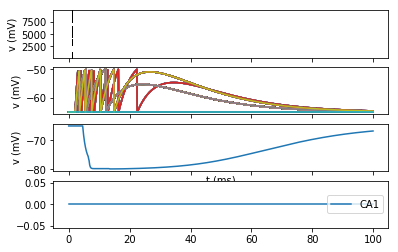

In [38]:
fig, ax = plt.subplots(nrows=4,sharex=True)
# ax.plot(trace.t/ms, trace.v/mV, label="CA3")
#raster_plot(inp)
for j in range(N_exc):
    ax[0].plot(trace.t/ms, trace.i, '|k', label="CA3")
for j in range(N_inh):
    ax[1].plot(trace1.t/ms, trace1[j].v/mV, label="I")
ax[2].plot(trace2.t/ms, trace2[0].v/mV, label="CA1")
ax[3].plot(trace2.t/ms, trace3[0].ge/nS, label="CA1")

# ax1 = fig.add_axes()
# ax1.plot(trace.t/ms, trace.i, c='b', label="CA3")

# ax[0].set_xlabel('t (ms)')
ax[0].set_ylabel('v (mV)')
# ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('v (mV)')
ax[2].set_xlabel('t (ms)')
ax[2].set_ylabel('v (mV)')

plt.legend(loc = 'center right')
plt.show()